# Importing the libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Loading the Dataset

In [2]:
with open("train_data.txt", encoding="utf8") as f:
    train_content = f.readlines()

with open("test_data_solution.txt", encoding="utf8") as f:
    content_test = f.readlines()

train = pd.DataFrame([element.split(":::") for element in train_content], columns=[
    'ID', 'TITLE', "GENRE", 'DESCRIPTION']).drop(columns=['ID'])

test = pd.DataFrame([element.split(":::") for element in content_test], columns=[
    'ID', 'TITLE', "GENRE", 'DESCRIPTION']).drop(columns=['ID'])

In [3]:
train.to_csv("train_data.csv", index=False)
test.to_csv("test_data.csv", index=False)

In [4]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [5]:
train.sample(5)

,TITLE,GENRE,DESCRIPTION
6775,Korabite sa palni (2005),documentary,This is a story of a journey by land and by s...
27773,Fragmented (2014),thriller,"When a woman's husband disappears abroad, the..."
51033,#WhyIMake PSA Featuring Actor Nick Offerman (...,short,"TV actor, comedian and woodworker Nick Offerm..."
19272,"""Playboy Video Magazine, Vol. 1"" (1983)",documentary,Playboy Video Magazine was literally a video ...
9173,Las cosas como son (2012),drama,Jerónimo is an antisocial person who rents ro...


In [6]:
train.shape, test.shape

((54214, 3), (54200, 3))

# EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54214 non-null  object
 1   GENRE        54214 non-null  object
 2   DESCRIPTION  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


***No null values in train as well as test data***

In [8]:
train.duplicated().sum()

0

***No duplicate values in train as well as test data***

In [9]:
train.describe()

,TITLE,GENRE,DESCRIPTION
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


***Searching For anomalies in the description***
<hr>

1. **@/twitter in the Description**

In [10]:
train.loc[train['DESCRIPTION'].str.contains(r'@\S+')].head()

,TITLE,GENRE,DESCRIPTION
242,Túlvilági beszélö (1992),documentary,Mail <svaradi@sprynet.com> for translation. T...
1880,Rokonok (1954),drama,Mail <svaradi@sprynet.com> for translation. F...
1986,Lila akác (1934),comedy,Mail <svaradi@sprynet.com> for translation. S...
6579,A csúnya lány (1935),comedy,Mail <svaradi@sprynet.com> for translation. D...
8296,Füszer és csemege (1940),drama,Mail <svaradi@sprynet.com> for translation. 5...


- we need to remove "Mail <svaradi@sprynet.com> for translation"<br>
- also from title we discovered that it contains title and description in different languages
<hr><br>

2. **HTTP links  in the Description**

In [11]:
train.loc[train['DESCRIPTION'].str.contains(r'http\S+')].head()

,TITLE,GENRE,DESCRIPTION
16974,The Happiness Matrix (2012),documentary,"Volume 1 of ""The Happiness Matrix"", a 2-hour ..."
20748,Blocking the Path to 9/11 (2008),documentary,There's more to the story of the Clintons and...
26257,"""Offbeat America"" (2005)",reality-tv,High Noon Entertainment hosts visit the Asian...
30651,Hollywood Love (1998),comedy,A feminist sex movie??? http:hollywoodlovemov...
33419,Trust 22 (2007),documentary,In this amazing film full of magic the direct...


- we need to remove the http links from the description<br>
<hr>

***We discovered above that the data contains different languages, hence Finding the language of all the descriptions.***

In [12]:
from langdetect import detect
lang_count=0
def detect_language(text):
    
    #for tracking the progress
    global lang_count
    lang_count=lang_count+1
    print(lang_count)
    
    #returning the code of language if found else unknown
    try:
        return detect(text)
    except:
        return 'Unknown'

In [ ]:
train['Language'] = train['DESCRIPTION'].apply(detect_language)
test['Language'] = test['DESCRIPTION'].apply(detect_language)

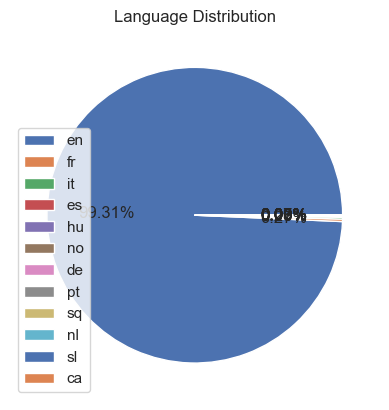

In [14]:
plt.pie(train.Language.value_counts().values.tolist(),autopct='%.2f%%')
plt.legend(labels=train.Language.value_counts().index.tolist(),loc='lower left')
plt.title('Language Distribution')
plt.show()

In [15]:
train["Language"].value_counts()

en    53841
fr      146
it      110
es       42
hu       37
no       16
de       16
pt        2
sq        1
nl        1
sl        1
ca        1
Name: Language, dtype: int64

***Some Descriptions are in different languages so we convert it to english later below which may help in increasing the accuracy***

# Text Cleaning

    text contains:
    1. Mentions
    2. Links
    3. punctuations
    4. unnecessary spaces
    5. single characters which has no meaning and it increases the dimentionality.
    6. one unknown email address

***hence we are removing these things from the text***

In [16]:
import re
import string
from nltk.corpus import stopwords
import nltk
stopwd = stopwords.words('english')
def clean_text(text):
    
    text= text.lower() # Lowercasing the text
    text = re.sub('Mail <svaradi@sprynet.com> for translation. ', '', text) # Removing unknown mail
    text = re.sub('-',' ',text.lower())   # Replacing `x-x` as `x x`
    text = re.sub(r'@\S+', '', text) # Removing mentions
    text = re.sub(r'http\S+', '', text) # Removing Links
    text = re.sub(f'[{string.punctuation}]', '', text) # Remove punctuations
    text = re.sub(f'[{string.digits}]', '', text) # Remove numbers
    text = re.sub(r'\s+', ' ', text) # Removing unnecessary spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Removing single characters
    
    words = nltk.tokenize.word_tokenize(text,language="english", preserve_line=True)
    text = " ".join([i for i in words if i not in stopwd and len(i)>2]) # Removing the stop words

    return text.strip()

In [17]:
clean_text(train["DESCRIPTION"][0])

'listening conversation doctor parents year old oscar learns nobody courage tell weeks live furious refuses speak anyone except straight talking rose lady pink meets hospital stairs christmas approaches rose uses fantastical experiences professional wrestler imagination wit charm allow oscar live life love full company friends pop corn einstein bacon childhood sweetheart peggy blue'

In [18]:
# applying clean text to train as well as test.
train["clean_description"]=train["DESCRIPTION"].apply(clean_text)
test["clean_description"]=test["DESCRIPTION"].apply(clean_text)

In [19]:
train.head(5)["clean_description"]

0    listening conversation doctor parents year old...
1    brother sister past incestuous relationship cu...
2    bus empties students field trip museum natural...
3    help unemployed father make ends meet edith tw...
4    films title refers recovered bodies ground zer...
Name: clean_description, dtype: object

**Checking the distribution of lengths of descriptions before and after cleaning**

In [20]:
train["len_desc"] = train["DESCRIPTION"].apply(len)
train["len_clean_desc"] = train["clean_description"].apply(len)

In [21]:
train.sample(5)

,TITLE,GENRE,DESCRIPTION,Language,clean_description,len_desc,len_clean_desc
29297,The Planet of Junior Brown (1997),drama,"This is the story of an extremely obese, rath...",en,story extremely obese rather immature yet brig...,893,510
43172,Just One Drink (????),thriller,Based on one of the most critically acclaimed...,en,based one critically acclaimed short films tim...,357,254
27651,Bomb Harvest (2007),documentary,"Laos: the most bombed country, per capita, on...",en,laos bombed country per capita planet australi...,380,266
50860,Illusion (2009/I),short,Joseph has just woken up from a coma to find ...,en,joseph woken coma find grandson memories life ...,400,237
20907,Paa Joe & The Lion (2016/I),documentary,Paa Joe dreams of his bygone days - bringing ...,en,paa joe dreams bygone days bringing money home...,632,417


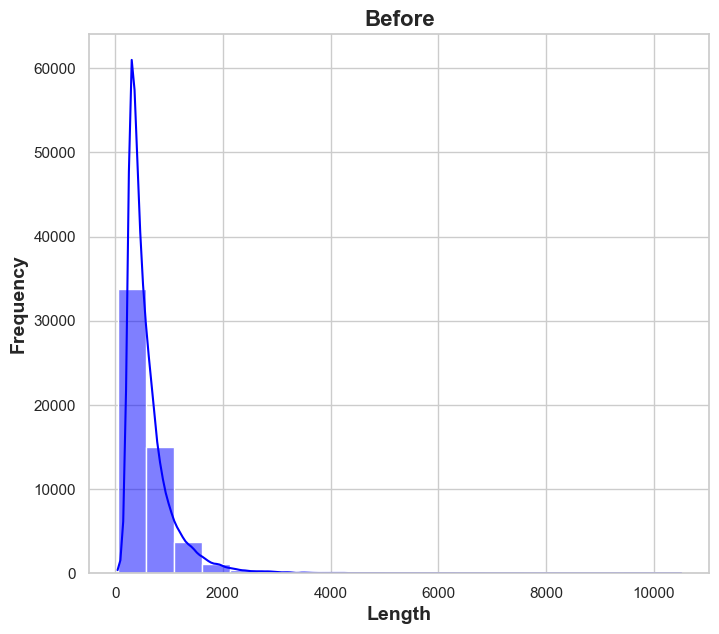

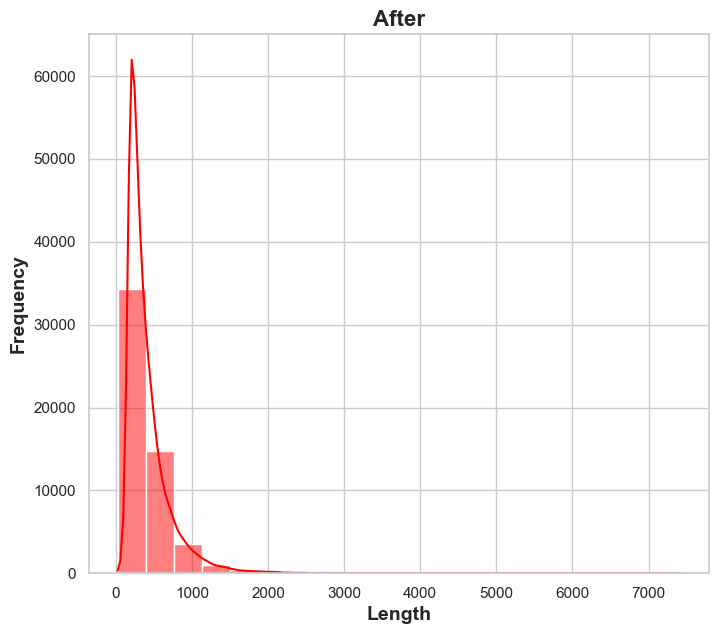

In [22]:
plt.figure(figsize=(8, 7))
sns.histplot(data=train, x='len_desc', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Before', fontsize=16, fontweight='bold')
plt.show()

plt.figure(figsize=(8, 7))
sns.histplot(data=train, x='len_clean_desc', bins=20, kde=True, color='red')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('After', fontsize=16, fontweight='bold')

plt.show()

In [23]:
#finding the number of descriptions with length greater than 2000
(train["len_clean_desc"]>2000).value_counts()

False    54012
True       202
Name: len_clean_desc, dtype: int64

In [24]:
# if length of description is greater 2000, we will truncate it randomly from 250 to 2000 because most of the description is less than 1500
train["clean_description"] = train["clean_description"].apply(lambda x: x[:np.random.randint(250,2000)] if len(x)>2000 else x)

In [26]:
#finding the number of descriptions with length greater than 2000
train["len_clean_desc"] = train["clean_description"].apply(len)
(train["len_clean_desc"]>2000).value_counts()

False    54214
Name: len_clean_desc, dtype: int64

In [28]:
from deep_translator import GoogleTranslator
translator = GoogleTranslator()
# translating the description to english if language is not english
def trans(text):
    try: 
        return translator.translate(text)
    except Exception as e:
        return text
    
train["clean_description"] = train.apply(lambda x: trans(x["clean_description"]) if x['Language']!='en' else x['clean_description'],axis=1)

In [29]:
train[train["Language"]!="en"].iloc[0]

TITLE                                  Divorzio alla siciliana (1963) 
GENRE                                                          comedy 
DESCRIPTION           Il barone Fifě ha bisogno di un erede per ave...
Language                                                            it
clean_description    Baron Fifě needs an heir to have his father's ...
len_desc                                                           645
len_clean_desc                                                     518
Name: 210, dtype: object

In [30]:
detect_language(train[train["Language"]!="en"].iloc[0]["clean_description"])

108415


'en'

***Lametizing the text*** : i.e. converting all the words to its root form to reduce the dimentionalty as well as help in improving the accuracy

- e.g <strong>changes</strong> and <strong>changing</strong> are two different entities if lametized it becomes <strong>change</strong>

In [31]:
import spacy
nlp = spacy.load("en_core_web_sm")
lam_cnt = 0 
def lametize(text):

    #for tracking the progress
    global lam_cnt
    lam_cnt=lam_cnt+1
    print(lam_cnt)
    

    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [32]:
lametize("I am going to the store")

'I be go to the store'

In [33]:
train["clean_description"] = train["clean_description"].apply(lambda x: lametize(x))

In [34]:
train.sample(5)

,TITLE,GENRE,DESCRIPTION,Language,clean_description,len_desc,len_clean_desc
1217,Bed of the Dead (2016),horror,Four twentysomethings find themselves stuck o...,en,four twentysomething find stick haunt antique ...,248,177
46081,Parta hic (1977),comedy,Engineer Laciga is going away on a two-month ...,en,engineer laciga go away two month work trip po...,788,528
31251,Petelinji zajtrk (2007),drama,"After being fired, a young car mechanic Djuro...",en,fire young car mechanic djuro get recommendati...,295,215
47898,"""Mama"" (2014)",drama,A single mom who has been only focusing on ma...,en,single mom focus make money achieve fame sudde...,526,312
4803,The Erotic World of Angel Cash (1982),adult,"Take the graceful, sensual world of classical...",en,take graceful sensual world classical ballet s...,262,175


In [35]:
train.drop(columns=["len_desc","len_clean_desc","Language","DESCRIPTION"],inplace=True)

***Merging title and Description***

In [37]:
train["input"] = train["TITLE"]+" "+train["clean_description"]
test["input"] = test["TITLE"]+" "+test["clean_description"]

# Analysis of the GENRE of movies

In [38]:
train["GENRE"].unique(),train["GENRE"].unique().shape

(array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
        ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
        ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
        ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
        ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
        ' musical ', ' war '], dtype=object),
 (27,))

***there are total of 27 different genres in the data***

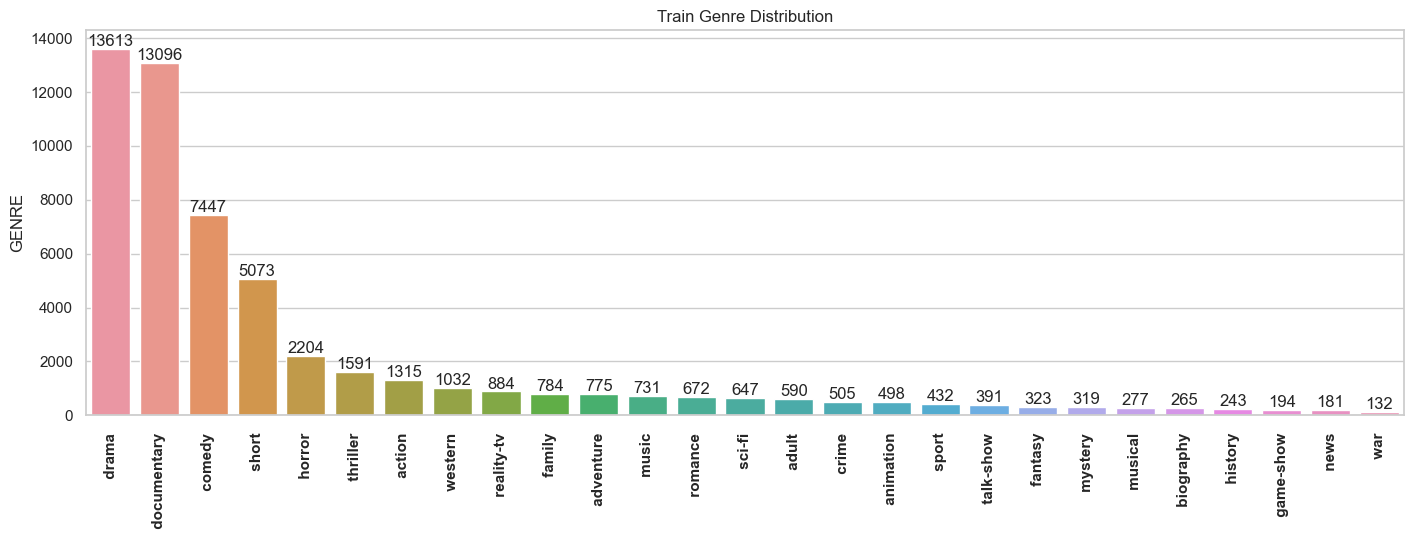

In [39]:
plt.subplots(figsize=(17, 5))
ax1 = sns.barplot(x=train["GENRE"].value_counts().index,
            y=train["GENRE"].value_counts())
ax1.bar_label(ax1.containers[0])
plt.title("Train Genre Distribution")
plt.xticks(rotation=90,fontweight="bold")
plt.show()

**_we can clearly see that the class is highly imbalance in training and testing data._**

<hr>

**Hence in order to avoid the imbalance we can use the random sampler**<br>

# Vectorizing using tfidf

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

# removing stopwords
# removing words with frequency lower than 20 in the whole corpus
# ngram(1,2) i.e if text is: "this is a sentence" 
# then vectors will be like:
# this, is, a, sentence, this is, is a, a sentence.

tfidf = TfidfVectorizer(stop_words='english',max_features=35000)

In [54]:
X_train_transformed = tfidf.fit_transform(train["input"])
X_test_transformed = tfidf.transform(test["input"])

***Increasing the data using the random sampler to avoid the imbalance in the class***

In [55]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=42)
# We will pass to it the output of TfidfVectorizer from train data
x_train_resampled, y_train_resampled = sampler.fit_resample(
    X_train_transformed, train['GENRE'])

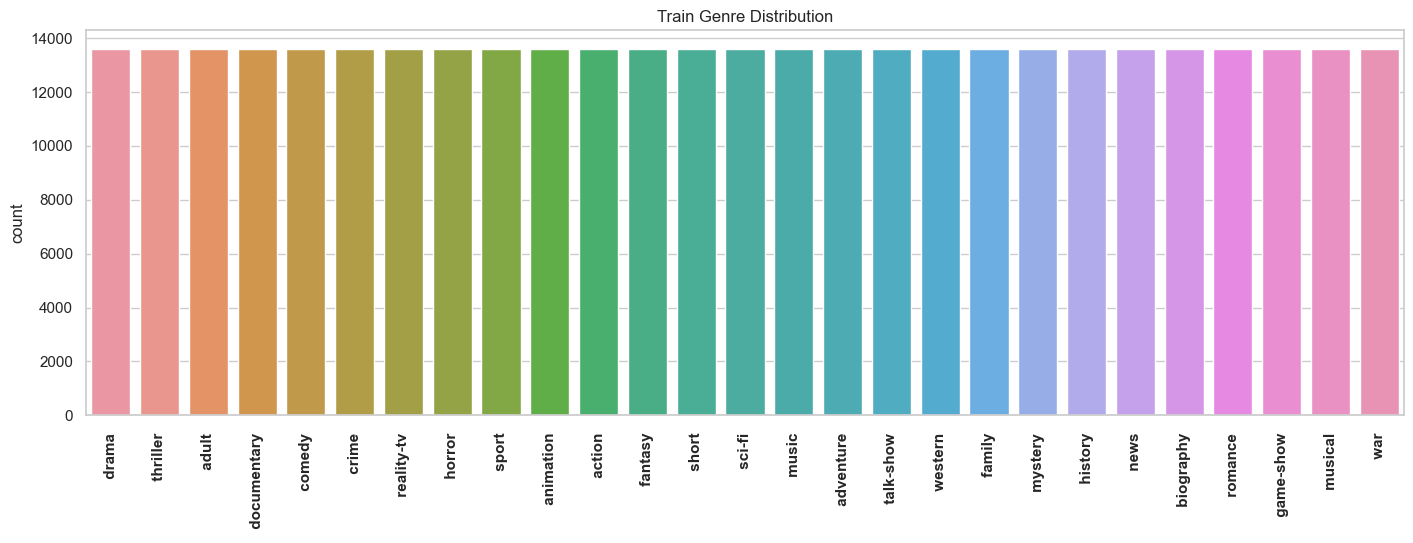

In [56]:
plt.subplots(figsize=(17, 5))
sns.countplot(data=y_train_resampled,x=y_train_resampled.values)
plt.title("Train Genre Distribution")
plt.xticks(rotation=90,fontweight="bold")
plt.show()

In [57]:
x_train_resampled.shape, y_train_resampled.shape

((367551, 35000), (367551,))

***Encoding the Genres using the label encoder***

In [58]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train_resampled)
y_test = encoder.transform(test["GENRE"])

***Word cloud of the most words present in the corpus***

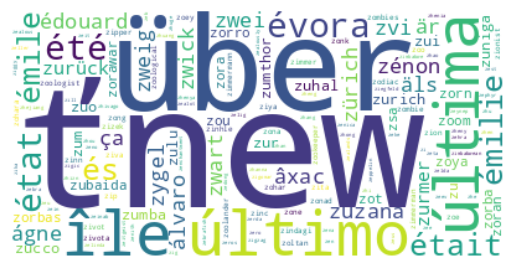

In [59]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    max_words=200, background_color="white").generate_from_frequencies(tfidf.vocabulary_)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

***Modelling***

- Logistic Regression
- Naive bayes
- RandomForest
- Support Vector Classifier

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


mnb = MultinomialNB(alpha=0.5)
gnb = GaussianNB()
bnb = BernoulliNB()
lgc = LogisticRegression(solver="sag", C=0.5, max_iter=500,
                         random_state=42, tol=0.1, n_jobs=4)
svc = LinearSVC()
rdmfr = RandomForestClassifier(n_estimators=100, random_state=42)
dcst = DecisionTreeClassifier()

In [61]:
x_train_resampled.shape,y_train.shape

((367551, 35000), (367551,))

In [62]:
lgc.fit(x_train_resampled, y_train)
lgc.score(X_test_transformed, y_test)

0.5159040590405904

In [63]:
bnb.fit(x_train_resampled, y_train)
bnb.score(X_test_transformed, y_test)

0.5271955719557195

In [64]:
mnb.fit(x_train_resampled, y_train)
mnb.score(X_test_transformed, y_test)

0.5165313653136532

In [65]:
rdmfr.fit(x_train_resampled, y_train)
rdmfr.score(X_test_transformed, y_test)

0.48837638376383763

In [66]:
svc.fit(x_train_resampled,y_train)
svc.score(X_test_transformed,y_test)

C:\Users\Pankil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.4830811808118081

In [72]:
ypred_test_lgc = lgc.predict(X_test_transformed)
ypred_train_lgc = lgc.predict(x_train_resampled)

ypred_test_bnb = bnb.predict(X_test_transformed)
ypred_train_bnb = bnb.predict(x_train_resampled)

ypred_test_mnb = mnb.predict(X_test_transformed)
ypred_train_mnb = mnb.predict(x_train_resampled)

ypred_test_rdmfr = rdmfr.predict(X_test_transformed)
ypred_train_rdmfr = rdmfr.predict(x_train_resampled)

ypred_test_svc = svc.predict(X_test_transformed)
ypred_train_svc = svc.predict(x_train_resampled)

In [73]:
from sklearn.metrics import classification_report, accuracy_score

print("Logistic Regression : ")
print("Train accuracy: ", accuracy_score(y_train, ypred_train_lgc))
print("Test accuracy: ", accuracy_score(y_test, ypred_test_lgc))

print("\n\nBernoulliNB : ")
print("Train accuracy: ", accuracy_score(y_train, ypred_train_bnb))
print("Test accuracy: ", accuracy_score(y_test, ypred_test_bnb))

print("\n\nMultinomialNB : ")
print("Train accuracy: ", accuracy_score(y_train, ypred_train_mnb))
print("Test accuracy: ", accuracy_score(y_test, ypred_test_mnb))

print("\n\nRandom Forest : ")
print("Train accuracy: ", accuracy_score(y_train, ypred_train_rdmfr))
print("Test accuracy: ", accuracy_score(y_test, ypred_test_rdmfr))

print("\n\nSupport Vector : ")
print("Train accuracy: ", accuracy_score(y_train, ypred_train_svc))
print("Test accuracy: ", accuracy_score(y_test, ypred_test_svc))

Logistic Regression : 
Train accuracy:  0.9468998860022146
Test accuracy:  0.5159040590405904


BernoulliNB : 
Train accuracy:  0.9134487458883257
Test accuracy:  0.5271955719557195


MultinomialNB : 
Train accuracy:  0.9319468590753393
Test accuracy:  0.5165313653136532


Random Forest : 
Train accuracy:  1.0
Test accuracy:  0.48837638376383763


Support Vector : 
Train accuracy:  0.9908692943292223
Test accuracy:  0.4830811808118081


***Test accuracy can be improved if we apply all the preprocessing we applied to train data***

<AxesSubplot: title={'center': 'Logistic Regression Test: '}>

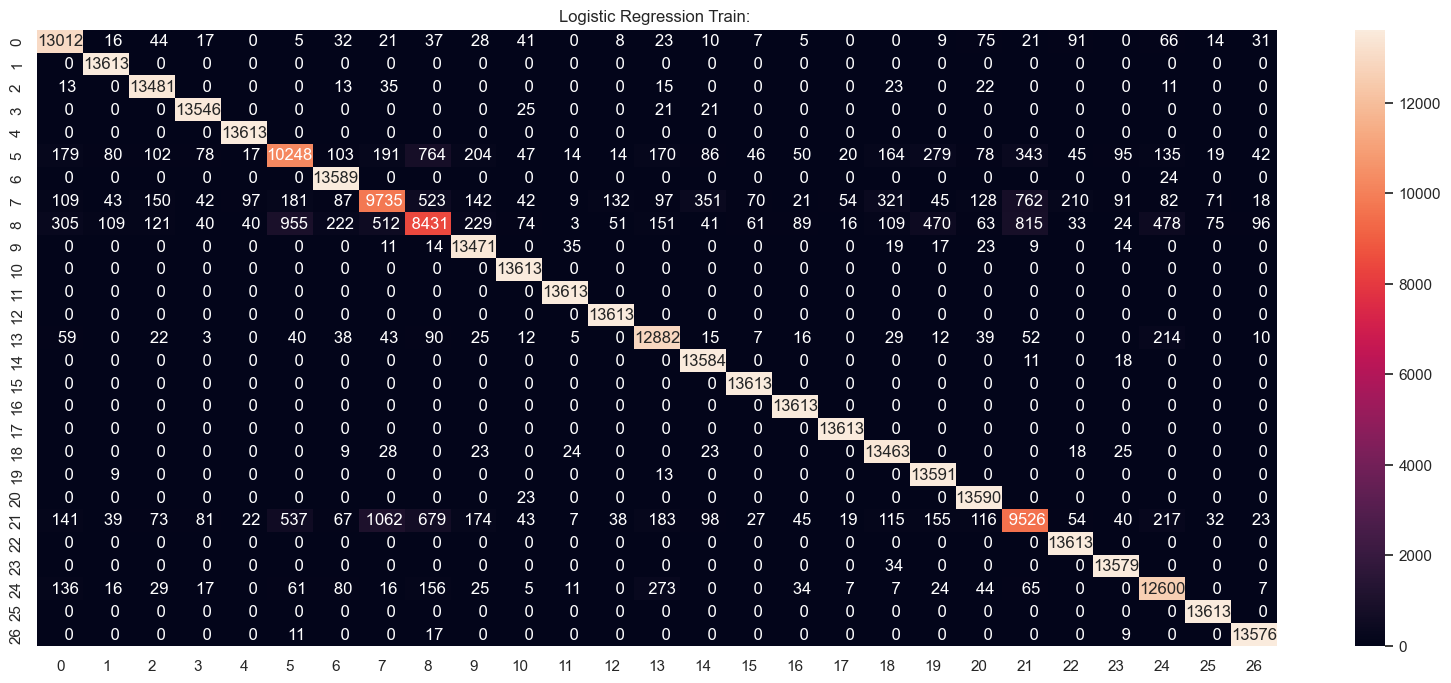

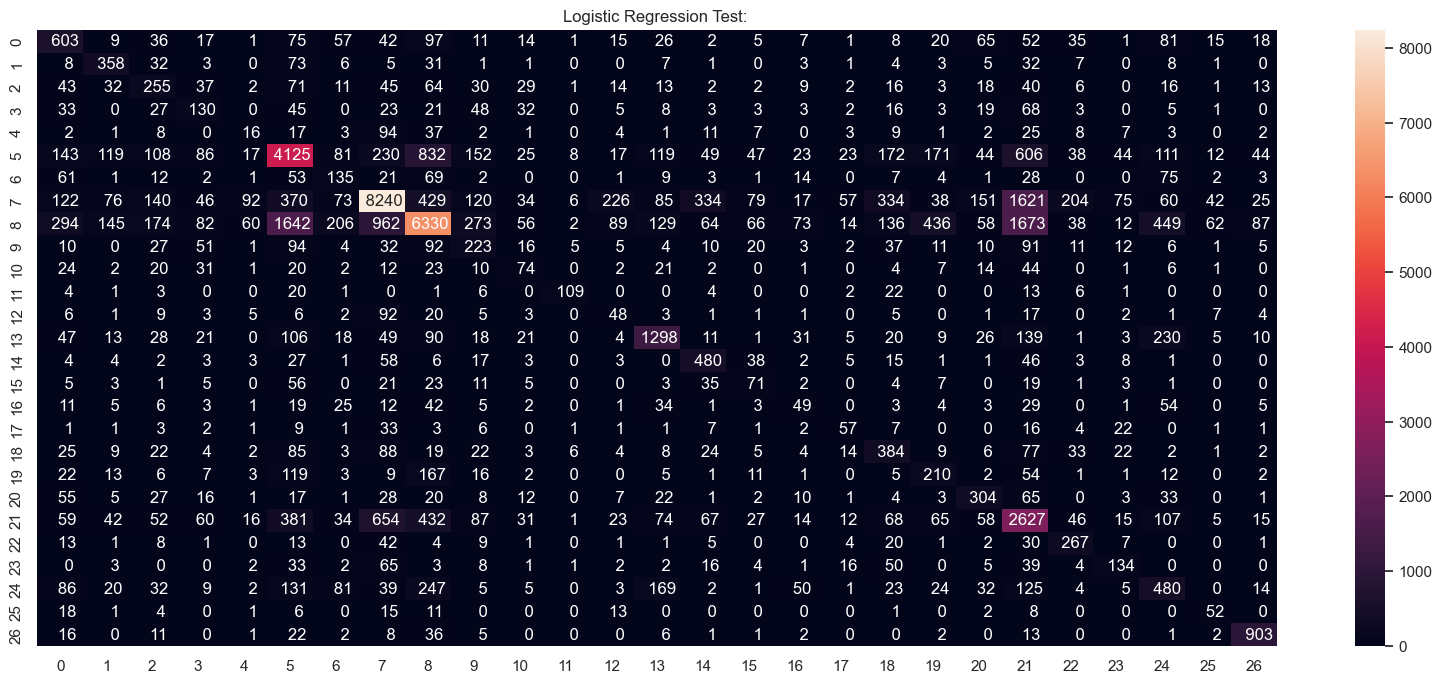

In [93]:
from sklearn.metrics import confusion_matrix,precision_score


cm1 = confusion_matrix(y_train,ypred_train_lgc)
plt.figure(figsize=(20,8))
plt.title("Logistic Regression Train: ")
sns.heatmap(cm1,annot=True,fmt="5g")

cm2 = confusion_matrix(y_test,ypred_test_lgc)
plt.figure(figsize=(20,8))
plt.title("Logistic Regression Test: ")
sns.heatmap(cm2,annot=True,fmt="5g")

In [75]:
scores = [{"Model":"Logistic Regression","Train Accuracy":0.9468998860022146,"Test Accuracy":0.5159040590405904},
         {"Model":"BernoulliNB","Train Accuracy":0.9134487458883257,"Test Accuracy":0.5271955719557195},
         {"Model":"MultinomialNB","Train Accuracy":0.9319468590753393,"Test Accuracy":0.5165313653136532},
         {"Model":"Random Forest","Train Accuracy":1.0,"Test Accuracy":0.48837638376383763},
         {"Model":"Support Vector","Train Accuracy":0.9908692943292223,"Test Accuracy":0.4830811808118081}]

scoresdf = pd.DataFrame(scores)

***Exporting Models, Vectorizer, Encoder uisng Pickle***

In [94]:
import pickle as pkl

In [95]:
pkl.dump(scoresdf, open("scores.pkl", "wb"))
pkl.dump(encoder, open("encoder.pkl", "wb"))
pkl.dump(tfidf, open("vectorizer.pkl", "wb"))
pkl.dump(lgc, open("logistic.pkl", "wb"))
pkl.dump(mnb, open("mnb.pkl", "wb"))
pkl.dump(bnb, open("bnb.pkl", "wb"))
pkl.dump(rdmfr, open("rdmfr.pkl", "wb"))
pkl.dump(svc, open("svc.pkl", "wb"))

***Testing the performance of XGboost***

In [96]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

xgb.fit(x_train_resampled, y_train)
xgb.score(X_test_transformed, y_test)

0.43055350553505534